In [23]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
from EfficientParticleTransformer import EfficientParticleTransformer


IndentationError: unindent does not match any outer indentation level (EfficientParticleTransformer.py, line 500)

In [26]:
0.1+0.1+0.1 == 0.3


False

In [ ]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [ ]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [ ]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [ ]:
tree = uproot.open('JetClass_example_100k.root')['tree']

In [ ]:
table = build_features_and_labels(tree)


In [2]:
x_particles = table['pf_features']
x_jets = table['pf_vectors']
y = table['label']
x_points = table['pf_points']
x_mask = table['pf_mask']

NameError: name 'table' is not defined

In [3]:
r_indexes = np.arange(len(x_particles))
np.random.shuffle(r_indexes)


NameError: name 'x_particles' is not defined

In [4]:
x_particles_train=x_particles[r_indexes][0:10000]
x_jets_train=x_jets[r_indexes][0:10000]
y_train=y[r_indexes][0:10000]
x_points_train=x_points[r_indexes][0:10000]
x_mask_train=x_mask[r_indexes][0:10000]

NameError: name 'x_particles' is not defined

In [5]:
x_part_test=x_particles[r_indexes][20000:21000]
x_jet_test=x_jets[r_indexes][20000:21000]
y_test=y[r_indexes][20000:21000]
x_points_test=x_points[r_indexes][20000:21000]
x_mask_test=x_mask[r_indexes][20000:21000]

NameError: name 'x_particles' is not defined

In [6]:
x_particles_train.shape

NameError: name 'x_particles_train' is not defined

In [7]:
x_part_test = x_particles[1000:2000]
for b in range(9):
    x_part_test = np.append(x_part_test, x_particles[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

NameError: name 'x_particles' is not defined

In [8]:
y_test = y[1000:2000]
for b in range(9):
    y_test = np.append(y_test, y[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

NameError: name 'y' is not defined

In [9]:
X_train_P = x_particles[2000:3000]
for b in range(9):
    x_part_test = np.append(X_train_P, x_particles[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)
y_train = y[2000:3000]
for b in range(9):
    y_train = np.append(y_train, y[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)
X_train_J = x_jets[2000:3000]
for b in range(9):
    X_train_J = np.append(X_train_J, x_jets[(b+1)*10000+4000:(b+1)*10000+5000], axis = 0)

NameError: name 'x_particles' is not defined

In [10]:
x_jet_test = x_jets[1000:2000]
for b in range(9):
    x_jet_test = np.append(x_jet_test, x_jets[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

NameError: name 'x_jets' is not defined

In [11]:
x_mask_test = x_mask[1000:2000]
for b in range(9):
    x_mask_test = np.append(x_mask_test, x_mask[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

NameError: name 'x_mask' is not defined

In [12]:
x_points_test = x_points[1000:2000]
for b in range(9):
    x_points_test = np.append(x_points_test, x_points[(b+1)*10000+1000:(b+1)*10000+2000], axis = 0)

NameError: name 'x_points' is not defined

In [13]:
x_part_test1 = x_particles[100:200]
for b in range(9):
    x_part_test1 = np.append(x_part_test1, x_particles[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
y_test1= y[100:200]
for b in range(9):
    y_test1 = np.append(y_test1, y[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_jet_test1 = x_jets[100:200]
for b in range(9):
    x_jet_test1 = np.append(x_jet_test1, x_jets[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_mask_test1 = x_mask[100:200]
for b in range(9):
    x_mask_test1 = np.append(x_mask_test1, x_mask[(b+1)*10000+100:(b+1)*10000+200], axis = 0)
x_points_test1 = x_points[100:200]
for b in range(9):
    x_points_test1 = np.append(x_points_test1, x_points[(b+1)*10000+100:(b+1)*10000+200], axis = 0)

NameError: name 'x_particles' is not defined

In [14]:
class EfficientParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = EfficientParticleTransformer(**kwargs)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        return self.mod(features, v=lorentz_vectors, mask=mask)


def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=0, # 4,
        use_pre_activation_pair=False,
        embed_dims=[32, 32, 32],
        pair_embed_dims=[32, 32, 32],
        num_heads=2,
        num_layers=2,
        num_cls_layers=1,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = EfficientParticleTransformerWrapper(**cfg)

    model_info = {
      
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [15]:
model, modInf = get_model()

NameError: name 'EfficientParticleTransformer' is not defined

In [16]:
total_params = sum(p.numel() for p in model.parameters())


NameError: name 'model' is not defined

In [17]:
total_params

NameError: name 'total_params' is not defined

In [18]:
model

NameError: name 'model' is not defined

In [19]:
from torch.utils.data import Dataset, DataLoader


In [20]:
learning_rate = 1e-4
dataloader = DataLoader(x_particles_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
ydataloader = DataLoader(y_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xjdataloader = DataLoader(x_jets_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xpointloader = DataLoader(x_points_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xmaskloader = DataLoader(x_mask_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

NameError: name 'x_particles_train' is not defined

In [210]:
loss_fn = torch.nn.CrossEntropyLoss()


In [211]:
b.shape 


torch.Size([16, 1, 128])

In [212]:
import torch.optim as optim


In [213]:
trainloss = np.zeros(100)
valloss = np.zeros(100)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for t in range(100):
    for x,y,z,a,b in zip(dataloader,ydataloader, xjdataloader,xpointloader,xmaskloader):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __c|all__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        
        y_pred = model(a.float(), x.float(), z.float(), b.float())

        loss = loss_fn(y_pred, torch.max(y.float(),1)[1])

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable   
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        trainloss[t] = loss
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        optimizer.step()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test))
    yloss = loss_fn(y_pred, torch.max(torch.from_numpy(y_test),1)[1])
    valloss[t] = yloss
    print('Epoch' +' ' +str(t+1) + ' Train Loss:' +str(trainloss[t]))
    print('        ' + 'Val Loss:' + str(valloss[t]))

Epoch 1 Train Loss:1.7822506427764893
        Val Loss:1.7218167781829834
Epoch 2 Train Loss:1.4116711616516113
        Val Loss:1.4593535661697388
Epoch 3 Train Loss:1.1628223657608032
        Val Loss:1.3596726655960083
Epoch 4 Train Loss:1.0933382511138916
        Val Loss:1.2439088821411133
Epoch 5 Train Loss:1.0144848823547363
        Val Loss:1.2390202283859253
Epoch 6 Train Loss:1.0005160570144653
        Val Loss:1.1719670295715332
Epoch 7 Train Loss:1.0402750968933105
        Val Loss:1.2917886972427368
Epoch 8 Train Loss:1.0324478149414062
        Val Loss:1.1138765811920166
Epoch 9 Train Loss:1.0212469100952148
        Val Loss:1.1766107082366943
Epoch 10 Train Loss:1.036776065826416
        Val Loss:1.0906118154525757
Epoch 11 Train Loss:0.971494734287262
        Val Loss:1.099921464920044
Epoch 12 Train Loss:1.0561285018920898
        Val Loss:1.1970452070236206
Epoch 13 Train Loss:1.0427311658859253
        Val Loss:1.0899906158447266
Epoch 14 Train Loss:1.080208897590637

In [215]:
torch.save(model,'torchModelLinformer')



In [216]:
import matplotlib.pyplot as plt

In [217]:
def learningCurve(trainloss,valloss):
    plt.figure(figsize=(10,8))
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

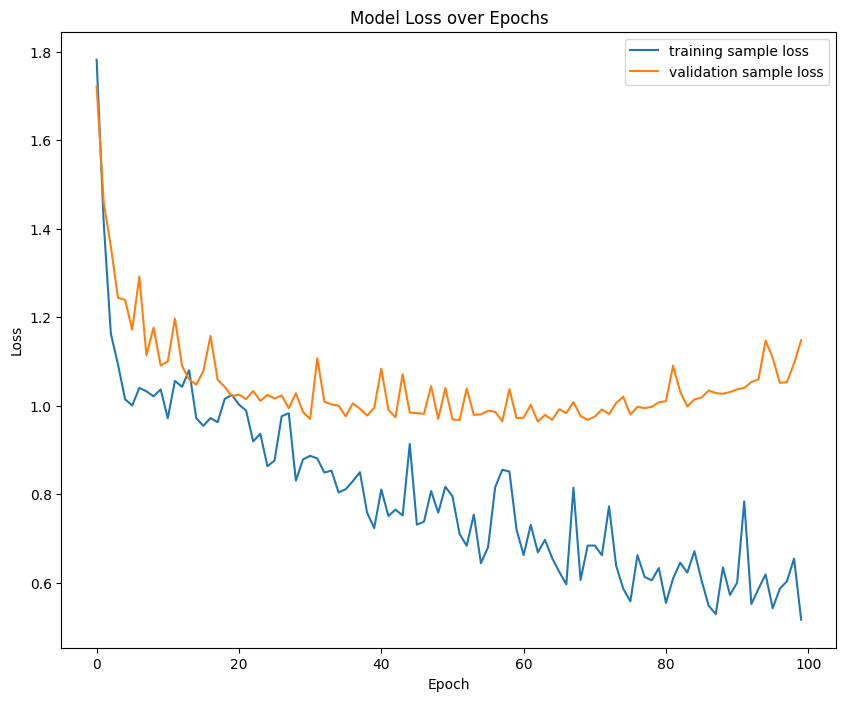

In [218]:
learningCurve(trainloss,valloss)


In [219]:
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']


In [227]:
def makeRoc(features1,feat2,feat3,feat4, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    with torch.no_grad():

        labels_pred = model(torch.from_numpy(features1),torch.from_numpy(feat2),torch.from_numpy(feat3),torch.from_numpy(feat4))
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    g = labels_pred.detach().numpy()
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = g[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Linformer (No Pair) ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [228]:
import pandas as pd

tensor([[-0.4224, -0.1323, -2.8691,  ...,  0.2159, -0.8040,  8.2815],
        [-1.0572,  1.4442,  5.8752,  ..., -4.1567, -0.0858, -3.4663],
        [-2.9669,  0.0993,  1.1560,  ..., -1.4924,  1.9730,  0.0632],
        ...,
        [-0.7939,  5.9307,  2.1674,  ..., -5.6288,  2.7192, -3.5140],
        [ 5.1717, -3.6868,  1.0211,  ...,  1.5162, -4.1941, -3.8674],
        [-0.9149,  4.4942, -1.0757,  ..., -2.9970,  0.2179,  7.8628]])

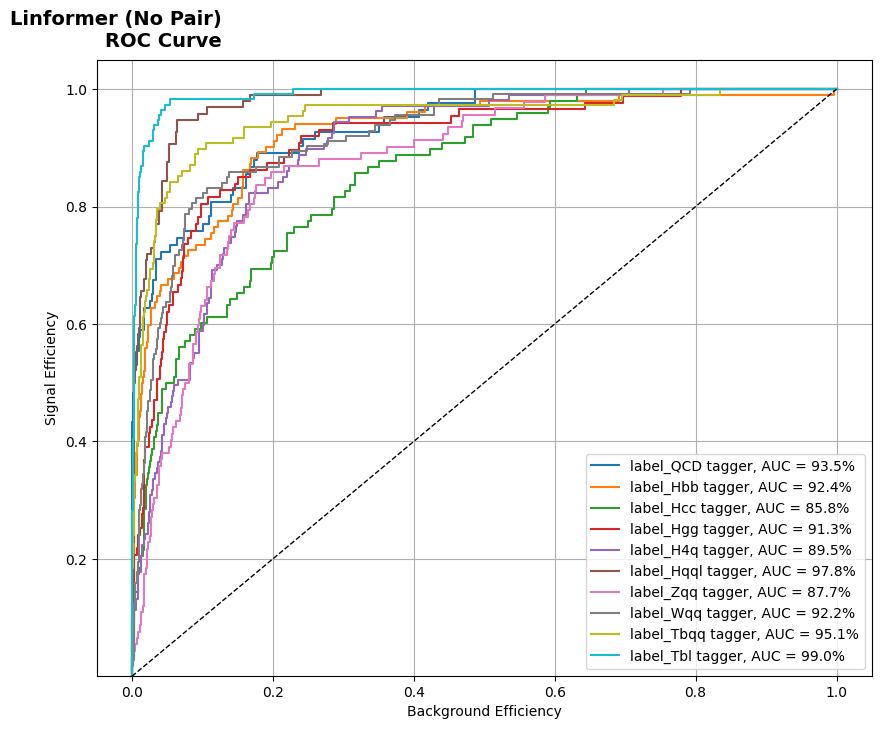

In [229]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)

tensor([[ 0.1898,  0.1171, -3.0622,  ...,  0.6715, -0.9102,  8.1219],
        [-1.5117,  1.6329,  6.0486,  ..., -3.7001, -0.4264, -2.9541],
        [-2.7562,  0.0865,  1.2654,  ..., -1.5413,  3.0243, -0.8610],
        ...,
        [-0.0690,  5.3414,  1.7180,  ..., -5.6761,  2.3389, -3.1653],
        [ 4.2917, -3.5000,  1.2488,  ...,  1.9530, -4.7770, -3.4524],
        [-0.4459,  4.9761, -0.6957,  ..., -3.4972,  1.2584,  6.5808]])

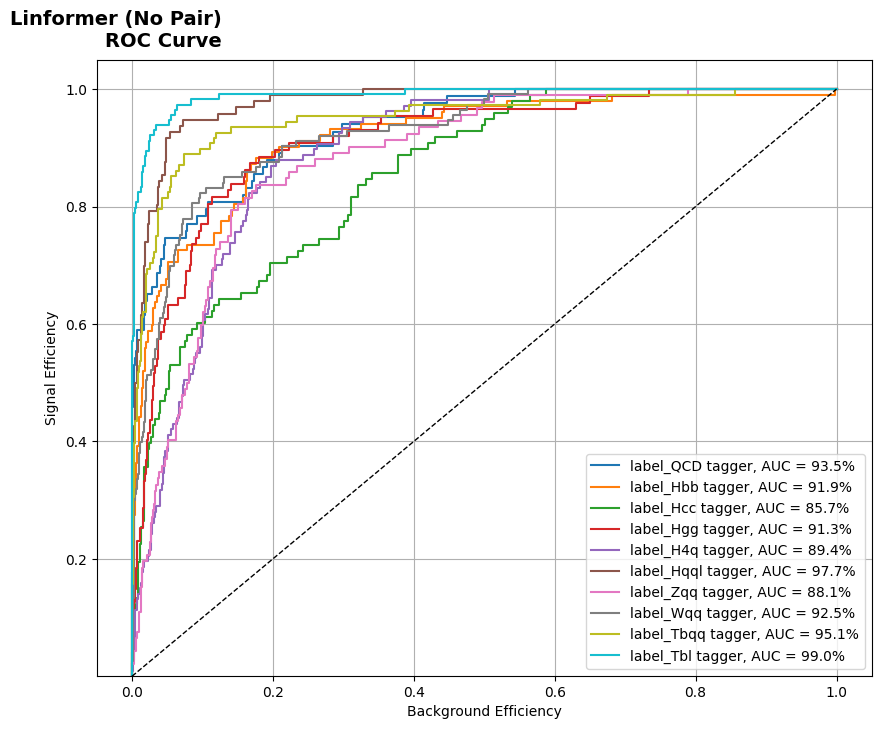

In [230]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)